# Wav2vec Evaluation On Stutterance

1. Turn original transcripts into dataframes
2. Read generated transcript dataframes
3. Get Error & Stutterance count
4. Get Error & Stutterance Type ==> show which stutterance type is more prone to error
5. Calculate Correlation Score
6. Generate Heatmap
7. Summarize Trend

*** 

### Error Metrics
1. Net / Total Word Error Rate
2. Word Error Rate Specific After Cleaning other Stutterance Type Annotations

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [2]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [3]:
!pip install pandas numpy scipy tqdm Rouge

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


---

## Word Error Rate

Objectives:
* split sequence into characters
* count:
    * deletion: missing words
    * substitutions: wrongly recognized words
    * insertions: extra words

In [4]:
def wer(candidate, reference):
    """
    Parameter(s)
    ------------
    candidate ==> generated transcript
    reference ==> dataset transcript
    """
    
    candidate_tokens = list(candidate)
    reference_tokens = list(reference)
    
    cand_len = len(candidate_tokens)
    ref_len = len(reference_tokens)
    
    dist_mat = np.zeros((ref_len, cand_len), dtype=int)
    
    for i in range(ref_len):
        dist_mat[i][0] = i
    for j in range(cand_len):
        dist_mat[0][j] = j
        
    for i in range(1, ref_len):
        for j in range(1, cand_len):
            if (candidate_tokens[j - 1] == reference_tokens[i - 1]):
                cost = 0
            else:
                cost = 1
                
            dist_mat[i][j] = min(
                dist_mat[i-1][j] + 1,
                dist_mat[i][j-1] + 1,
                dist_mat[i-1][j-1] + cost
            )
            # print(dist_mat)
            
    wer = dist_mat[-1][-1] / len(reference_tokens)
    return wer

***

## Imports and Data Ingestion (Wav2vec)

In [5]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [6]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 
net_aigenerated_data_wav2vec = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Wav2vec.csv", delimiter=",")

del net_aigenerated_data_wav2vec[net_aigenerated_data_wav2vec.columns[0]]

In [7]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [8]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [9]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [10]:
net_aigenerated_data_wav2vec

,Filename,Start_time,End_time,Wav2vec
0,D0001_A,2081.540000,2109.650000,我说出了就比较需要时间然后那识别了他的不就是他的一会那个话还没说完的描说出来的话它就取消不就...
1,D0001_A,790.130000,796.580000,四治表我尔说的法
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评中不怎么好的就而论区的那那县人他们都在说拿号作朝惨的那个就那么请奋但是就是了...
3,D0001_A,2016.780000,2035.673559,很金转和训非女婴还是讯本一助手来的就就我记的他是叫迅菲我之前甲就是他
4,D0001_A,1682.670000,1709.110000,一个那个是你较扎来的果望了是出现了与一个人然后了他他就这了一把健然后就交瓦那个拿二奥给早萨尔...
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已
37249,P0070,2782.496000,2783.706000,杨幂的电影
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样
37251,P0070,2604.066000,2606.656000,单曲循环歌曲刘离光之歌


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_wav2vec`**

***

## Wav2vec WER Analysis

In [11]:
na_count_large = 0
na_count_cleaned = 0
for index, row in tqdm(net_aigenerated_data_wav2vec.iterrows(), total=len(net_aigenerated_data_wav2vec)):
    
    mask_large = (
        (net_aigenerated_data_wav2vec["Filename"] == row["Filename"]) &
        (net_aigenerated_data_wav2vec["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_wav2vec.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    wav2vec = large_row["Wav2vec"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(wav2vec) or not isinstance(wav2vec, str):
        print("Skipping due to missing or non-string wav2vec.")
        na_count_large = na_count_large + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:
        
        wer_value = wer(wav2vec, cleaned_transcript)
        
        net_aigenerated_data_wav2vec.loc[mask_large, "WER"] = wer_value
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_wav2vec.loc[mask_large, "Stutterance_Count"] = stutterance_count

        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_whisper_large.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)
        
net_aigenerated_data_wav2vec = net_aigenerated_data_wav2vec.assign(NA_Count=na_count_large)
net_aigenerated_data_wav2vec = net_aigenerated_data_wav2vec.assign(NA_Cleaned_Count=na_count_cleaned)

  0%|          | 60/37253 [00:00<04:25, 140.32it/s]

Skipping due to missing or non-string wav2vec.


  0%|          | 142/37253 [00:00<04:05, 151.33it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  1%|          | 193/37253 [00:01<03:52, 159.53it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  1%|          | 314/37253 [00:02<03:41, 167.04it/s]

Skipping due to missing or non-string wav2vec.


  1%|▏         | 535/37253 [00:03<03:41, 165.45it/s]

Skipping due to missing or non-string wav2vec.


  2%|▏         | 821/37253 [00:05<03:40, 164.99it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  2%|▏         | 855/37253 [00:05<03:45, 161.71it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  2%|▏         | 889/37253 [00:05<03:47, 159.93it/s]

Skipping due to missing or non-string wav2vec.


  3%|▎         | 1123/37253 [00:07<03:33, 168.91it/s]

Skipping due to missing or non-string wav2vec.


  3%|▎         | 1271/37253 [00:07<03:38, 164.56it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  4%|▎         | 1353/37253 [00:08<04:00, 149.11it/s]

Skipping due to missing or non-string wav2vec.


  4%|▍         | 1445/37253 [00:09<04:05, 145.71it/s]

Skipping due to missing or non-string wav2vec.


  4%|▍         | 1508/37253 [00:09<03:55, 151.75it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  4%|▍         | 1633/37253 [00:10<03:57, 149.90it/s]

Skipping due to missing or non-string wav2vec.


  4%|▍         | 1668/37253 [00:10<03:45, 158.15it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▍         | 1702/37253 [00:10<03:39, 162.21it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▍         | 1845/37253 [00:11<03:36, 163.64it/s]

Skipping due to missing or non-string wav2vec.
Skipping: One of the rows is empty.


  5%|▌         | 1960/37253 [00:12<03:51, 152.20it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▌         | 1993/37253 [00:12<03:44, 157.03it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▌         | 2025/37253 [00:12<03:53, 150.98it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  6%|▌         | 2058/37253 [00:13<03:47, 154.43it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  6%|▌         | 2158/37253 [00:13<03:40, 158.93it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2469/37253 [00:15<04:00, 144.51it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2581/37253 [00:16<03:38, 158.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2615/37253 [00:16<03:33, 162.61it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2667/37253 [00:17<03:31, 163.80it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2702/37253 [00:17<03:27, 166.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2753/37253 [00:17<03:40, 156.51it/s]

Skipping due to missing or non-string wav2vec.


  7%|▋         | 2784/37253 [00:17<04:02, 142.17it/s]

Skipping due to missing or non-string wav2vec.


  8%|▊         | 2829/37253 [00:18<04:08, 138.75it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  8%|▊         | 2871/37253 [00:18<04:10, 137.15it/s]

Skipping due to missing or non-string wav2vec.


  8%|▊         | 2919/37253 [00:18<03:49, 149.40it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  8%|▊         | 3032/37253 [00:19<03:54, 146.23it/s]

Skipping due to missing or non-string wav2vec.


  9%|▊         | 3227/37253 [00:21<04:14, 133.61it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3369/37253 [00:22<04:21, 129.68it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3396/37253 [00:22<04:25, 127.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  9%|▉         | 3461/37253 [00:22<04:31, 124.32it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3487/37253 [00:23<04:36, 122.04it/s]

Skipping due to missing or non-string wav2vec.


 10%|▉         | 3542/37253 [00:23<04:14, 132.40it/s]

Skipping due to missing or non-string wav2vec.


 10%|▉         | 3724/37253 [00:24<03:20, 167.00it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 10%|█         | 3761/37253 [00:24<03:13, 173.36it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 10%|█         | 3797/37253 [00:25<03:13, 172.65it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 10%|█         | 3851/37253 [00:25<03:13, 172.59it/s]

Skipping due to missing or non-string wav2vec.


 11%|█         | 3923/37253 [00:25<03:14, 170.93it/s]

Skipping due to missing or non-string wav2vec.


 11%|█         | 4031/37253 [00:26<03:11, 173.61it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4085/37253 [00:26<03:11, 173.10it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4139/37253 [00:27<03:09, 174.78it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4175/37253 [00:27<03:11, 173.03it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█▏        | 4211/37253 [00:27<03:19, 165.22it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█▏        | 4245/37253 [00:27<03:25, 160.44it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█▏        | 4279/37253 [00:27<03:30, 156.93it/s]

Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4394/37253 [00:28<03:26, 158.84it/s]

Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4431/37253 [00:28<03:12, 170.67it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4488/37253 [00:29<03:02, 179.96it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4578/37253 [00:29<03:15, 166.88it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4612/37253 [00:29<03:20, 162.82it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4681/37253 [00:30<03:14, 167.04it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4715/37253 [00:30<03:16, 165.78it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4750/37253 [00:30<03:12, 168.66it/s]

Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4924/37253 [00:31<03:20, 160.91it/s]

Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4958/37253 [00:32<03:18, 162.99it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 14%|█▎        | 5104/37253 [00:32<03:01, 176.94it/s]

Skipping due to missing or non-string wav2vec.


 14%|█▍        | 5246/37253 [00:33<03:16, 163.21it/s]

Skipping due to missing or non-string wav2vec.


 14%|█▍        | 5280/37253 [00:33<03:22, 158.08it/s]

Skipping due to missing or non-string wav2vec.


 14%|█▍        | 5331/37253 [00:34<03:21, 158.23it/s]

Skipping due to missing or non-string wav2vec.


 15%|█▍        | 5446/37253 [00:35<03:22, 157.14it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 15%|█▍        | 5559/37253 [00:35<03:23, 155.72it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5780/37253 [00:37<03:54, 134.38it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5812/37253 [00:37<03:38, 143.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5843/37253 [00:37<03:33, 147.18it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5874/37253 [00:38<03:31, 148.38it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5909/37253 [00:38<03:14, 161.10it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5963/37253 [00:38<03:04, 169.69it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 6013/37253 [00:38<03:18, 157.30it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 6045/37253 [00:39<03:19, 156.21it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▋        | 6078/37253 [00:39<03:20, 155.81it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6159/37253 [00:39<03:19, 156.09it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6244/37253 [00:40<03:05, 166.73it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6281/37253 [00:40<02:58, 173.91it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6317/37253 [00:40<02:58, 172.83it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6369/37253 [00:41<03:12, 160.67it/s]

Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6589/37253 [00:42<03:13, 158.09it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6742/37253 [00:43<03:14, 156.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6775/37253 [00:43<03:14, 157.07it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6823/37253 [00:44<03:19, 152.74it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 19%|█▊        | 6922/37253 [00:44<03:09, 159.99it/s]

Skipping due to missing or non-string wav2vec.


 19%|█▉        | 7010/37253 [00:45<02:59, 168.56it/s]

Skipping due to missing or non-string wav2vec.


 19%|█▉        | 7155/37253 [00:46<02:53, 173.70it/s]

Skipping due to missing or non-string wav2vec.


 19%|█▉        | 7243/37253 [00:46<03:08, 159.12it/s]

Skipping due to missing or non-string wav2vec.


 20%|█▉        | 7307/37253 [00:47<03:19, 150.16it/s]

Skipping due to missing or non-string wav2vec.


 20%|█▉        | 7435/37253 [00:47<03:13, 154.44it/s]

Skipping due to missing or non-string wav2vec.


 20%|██        | 7533/37253 [00:48<03:08, 157.85it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 20%|██        | 7565/37253 [00:48<03:07, 158.17it/s]

Skipping due to missing or non-string wav2vec.


 21%|██        | 7654/37253 [00:49<02:54, 169.60it/s]

Skipping due to missing or non-string wav2vec.


 21%|██        | 7707/37253 [00:49<02:54, 168.98it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 21%|██        | 7902/37253 [00:50<03:01, 161.76it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 21%|██▏       | 7970/37253 [00:51<03:00, 162.25it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 21%|██▏       | 8004/37253 [00:51<03:02, 160.24it/s]

Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8128/37253 [00:52<02:48, 172.97it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8164/37253 [00:52<02:56, 164.78it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8215/37253 [00:52<02:58, 162.71it/s]

Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8233/37253 [00:52<02:58, 162.74it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8369/37253 [00:53<02:53, 166.46it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8420/37253 [00:54<02:57, 162.53it/s]

Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8529/37253 [00:54<02:44, 174.75it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8632/37253 [00:55<02:57, 161.17it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8683/37253 [00:55<02:56, 161.60it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8717/37253 [00:55<03:01, 157.09it/s]

Skipping due to missing or non-string wav2vec.


 24%|██▎       | 8797/37253 [00:56<03:09, 149.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 24%|██▍       | 8936/37253 [00:57<03:17, 143.23it/s]

Skipping due to missing or non-string wav2vec.


 24%|██▍       | 9048/37253 [00:58<03:05, 152.24it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 25%|██▍       | 9217/37253 [00:59<02:52, 162.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 25%|██▌       | 9363/37253 [01:00<03:10, 146.67it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 25%|██▌       | 9393/37253 [01:00<03:12, 144.60it/s]

Skipping due to missing or non-string wav2vec.


 25%|██▌       | 9442/37253 [01:00<03:03, 151.69it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9526/37253 [01:01<02:50, 162.82it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9577/37253 [01:01<02:46, 165.92it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9628/37253 [01:01<02:54, 158.43it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9773/37253 [01:02<02:55, 156.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 26%|██▋       | 9821/37253 [01:02<02:59, 153.05it/s]

Skipping due to missing or non-string wav2vec.


 27%|██▋       | 9901/37253 [01:03<03:14, 140.90it/s]

Skipping due to missing or non-string wav2vec.


 27%|██▋       | 9934/37253 [01:03<03:01, 150.45it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 27%|██▋       | 9984/37253 [01:04<02:54, 156.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 27%|██▋       | 10090/37253 [01:04<02:41, 168.56it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10318/37253 [01:06<02:37, 170.50it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10391/37253 [01:06<02:33, 175.27it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10426/37253 [01:06<02:45, 162.16it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10459/37253 [01:06<02:49, 157.96it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping: One of the rows is empty.


 28%|██▊       | 10491/37253 [01:07<02:55, 152.35it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10572/37253 [01:07<02:52, 155.08it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▊       | 10621/37253 [01:07<02:49, 156.92it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▊       | 10689/37253 [01:08<02:40, 165.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10724/37253 [01:08<02:45, 160.30it/s]

Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10807/37253 [01:09<02:47, 158.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10880/37253 [01:09<02:30, 175.15it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10916/37253 [01:09<02:36, 168.41it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11000/37253 [01:10<02:48, 155.56it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11064/37253 [01:10<02:46, 157.09it/s]

Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11098/37253 [01:10<02:43, 159.75it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11164/37253 [01:11<02:48, 155.15it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11197/37253 [01:11<02:45, 157.35it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11278/37253 [01:12<02:44, 157.88it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11329/37253 [01:12<02:42, 159.99it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11362/37253 [01:12<02:52, 150.12it/s]

Skipping due to missing or non-string wav2vec.


 31%|███       | 11514/37253 [01:13<02:34, 166.21it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███       | 11551/37253 [01:13<02:29, 171.80it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███       | 11603/37253 [01:14<02:44, 156.30it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███       | 11635/37253 [01:14<02:49, 150.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███▏      | 11696/37253 [01:14<03:03, 139.47it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11742/37253 [01:15<02:55, 145.49it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11857/37253 [01:15<02:47, 151.46it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11892/37253 [01:16<02:38, 160.30it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11960/37253 [01:16<02:33, 165.00it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11995/37253 [01:16<02:35, 162.19it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 12030/37253 [01:16<02:34, 163.20it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 12064/37253 [01:17<02:32, 165.67it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 12098/37253 [01:17<02:34, 162.61it/s]

Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12166/37253 [01:17<02:36, 160.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12218/37253 [01:18<02:31, 165.33it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12253/37253 [01:18<02:29, 166.67it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12287/37253 [01:18<02:37, 158.35it/s]

Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12405/37253 [01:19<02:34, 160.71it/s]

Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12439/37253 [01:19<02:30, 164.53it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▎      | 12494/37253 [01:19<02:24, 170.80it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▎      | 12547/37253 [01:20<02:30, 164.03it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12581/37253 [01:20<02:33, 160.40it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12668/37253 [01:20<02:27, 166.49it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12736/37253 [01:21<02:34, 158.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12784/37253 [01:21<02:37, 155.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12832/37253 [01:21<02:40, 152.59it/s]

Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12864/37253 [01:22<02:41, 151.31it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12916/37253 [01:22<02:29, 162.94it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12981/37253 [01:22<02:43, 148.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 13031/37253 [01:23<02:34, 156.76it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13079/37253 [01:23<02:40, 150.23it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13111/37253 [01:23<02:38, 152.64it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13143/37253 [01:23<02:34, 155.92it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13175/37253 [01:24<02:34, 155.59it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13207/37253 [01:24<02:40, 149.58it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13257/37253 [01:24<02:30, 159.74it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13310/37253 [01:24<02:23, 166.63it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13344/37253 [01:25<02:24, 165.07it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13378/37253 [01:25<02:30, 158.95it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13427/37253 [01:25<02:29, 159.12it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13462/37253 [01:25<02:26, 162.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13497/37253 [01:26<02:21, 168.23it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▋      | 13553/37253 [01:26<02:15, 174.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13622/37253 [01:26<02:38, 149.12it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13653/37253 [01:27<02:46, 141.73it/s]

Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13683/37253 [01:27<02:42, 144.85it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13733/37253 [01:27<02:34, 152.51it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13785/37253 [01:27<02:22, 164.49it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13836/37253 [01:28<02:22, 164.15it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13871/37253 [01:28<02:21, 165.08it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13905/37253 [01:28<02:28, 157.39it/s]

Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13967/37253 [01:29<02:40, 145.11it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14015/37253 [01:29<02:33, 150.92it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14051/37253 [01:29<02:20, 164.83it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14123/37253 [01:30<02:13, 173.69it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14213/37253 [01:30<02:13, 173.01it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14268/37253 [01:30<02:17, 167.11it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14302/37253 [01:31<02:19, 165.09it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▊      | 14354/37253 [01:31<02:21, 161.52it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▊      | 14388/37253 [01:31<02:25, 157.33it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▊      | 14423/37253 [01:31<02:20, 162.75it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14475/37253 [01:32<02:17, 165.23it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14509/37253 [01:32<02:26, 154.88it/s]

Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14577/37253 [01:32<02:20, 161.94it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14647/37253 [01:33<02:17, 163.96it/s]

Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14681/37253 [01:33<02:21, 159.73it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14752/37253 [01:33<02:10, 172.36it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14806/37253 [01:34<02:09, 173.42it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14857/37253 [01:34<02:24, 154.54it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14889/37253 [01:34<02:29, 149.88it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|████      | 14937/37253 [01:35<02:31, 147.72it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|████      | 14972/37253 [01:35<02:22, 156.65it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|████      | 15022/37253 [01:35<02:19, 159.62it/s]

Skipping due to missing or non-string wav2vec.


 40%|████      | 15054/37253 [01:35<02:23, 154.38it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 53%|█████▎    | 19670/37253 [02:00<01:32, 189.60it/s]

Skipping due to missing or non-string wav2vec.


 66%|██████▋   | 24699/37253 [02:26<01:06, 189.26it/s]

Skipping due to missing or non-string wav2vec.


 91%|█████████▏| 34073/37253 [03:16<00:16, 189.42it/s]

Skipping: One of the rows is empty.
Skipping: One of the rows is empty.


 93%|█████████▎| 34607/37253 [03:19<00:14, 188.86it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [03:33<00:00, 174.36it/s]


In [15]:
net_aigenerated_data_wav2vec

,Filename,Start_time,End_time,Wav2vec,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出了就比较需要时间然后那识别了他的不就是他的一会那个话还没说完的描说出来的话它就取消不就...,0.350515,1.0,589,0
1,D0001_A,790.130000,796.580000,四治表我尔说的法,0.700000,1.0,589,0
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评中不怎么好的就而论区的那那县人他们都在说拿号作朝惨的那个就那么请奋但是就是了...,0.375000,10.0,589,0
3,D0001_A,2016.780000,2035.673559,很金转和训非女婴还是讯本一助手来的就就我记的他是叫迅菲我之前甲就是他,0.578947,7.0,589,0
4,D0001_A,1682.670000,1709.110000,一个那个是你较扎来的果望了是出现了与一个人然后了他他就这了一把健然后就交瓦那个拿二奥给早萨尔...,0.455882,8.0,589,0
...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,589,0
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,589,0
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,589,0
37251,P0070,2604.066000,2606.656000,单曲循环歌曲刘离光之歌,0.250000,0.0,589,0


In [16]:
# net_aigenerated_data_whisper_large.to_csv('net_aigenerated_data_whisper_large_wer_data.csv', sep=',')

***

## Visualization of Relationship between Stutterance Count and Word Error Rate (Wav2vec)

In [17]:
## Load data from csv if starting here

# net_aigenerated_data_whisper_large = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation/net_aigenerated_data_whisper_large_wer_data.csv', delimiter=',')

In [18]:
import matplotlib.pyplot as plt

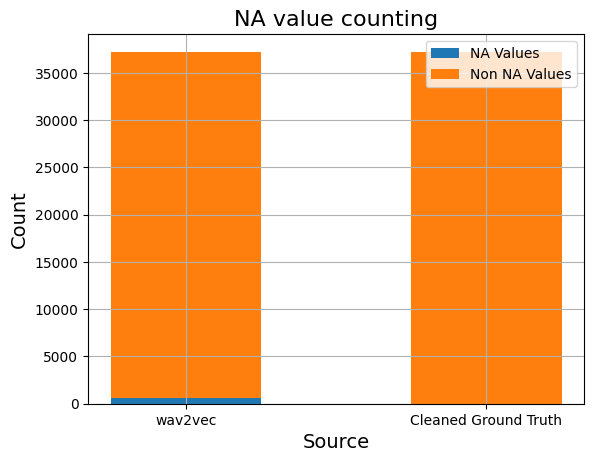

In [37]:
## Null value plots

nonnull_count_large = net_aigenerated_data_wav2vec["NA_Count"].count() - net_aigenerated_data_wav2vec.iloc[0]["NA_Count"]
null_count_large = net_aigenerated_data_wav2vec.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_wav2vec["NA_Cleaned_Count"].count() - net_aigenerated_data_wav2vec.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_wav2vec.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_large, null_count_cleaned],
    "Non NA Values": [nonnull_count_large, nonnull_count_cleaned],
}

species = (
    "wav2vec",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend()
ax.grid(True)

plt.show()

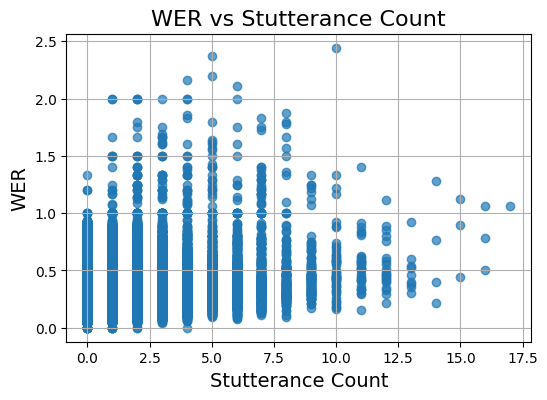

In [19]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

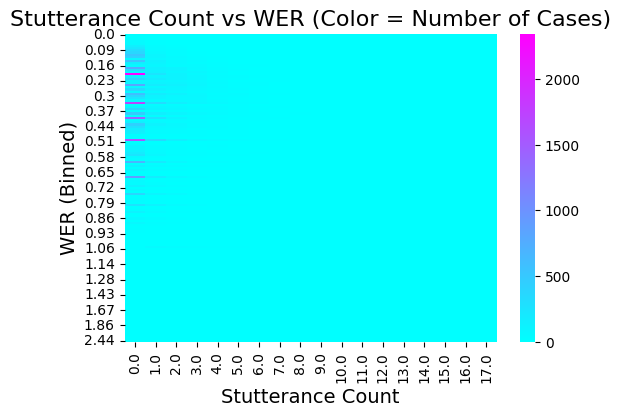

In [20]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_wav2vec['WER_Binned'] = np.round(net_aigenerated_data_wav2vec['WER'], 2)

grouped_data = net_aigenerated_data_wav2vec.groupby(
    ['Stutterance_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stutterance_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [21]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Stutterance_Count'], net_aigenerated_data_wav2vec.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 8.84946225121258e-20
rho = 0.047514594192494604


***

## ROUGE-N/L Scores (Semantic Evaluation) (Wav2vec)

In [17]:
pip install rouge_chinese jieba

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 172.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314458 sha256=5365f74fc635821beb632895b9b89abc25e4c6defe29e0ad2f5f6df47e4a232c
  Stored in directory: /scratch/291900.1.ood/pip-ephem-wheel-cache-iqbbtp08/wheels/c9/69/31/d56d90b22a1777b0b231e234b00302a55be255930f8bd92dcd
Successfully built jieba

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
from rouge_chinese import Rouge
import jieba

In [19]:
rouge = Rouge()

In [20]:
print_ = True

for index, row in tqdm(net_aigenerated_data_wav2vec.iterrows(), total=len(net_aigenerated_data_wav2vec)):
    
    mask_large = (
        (net_aigenerated_data_wav2vec["Filename"] == row["Filename"]) &
        (net_aigenerated_data_wav2vec["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_wav2vec.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    wav2vec = large_row["Wav2vec"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(wav2vec) or not isinstance(wav2vec, str):
        print("Skipping due to missing or non-string wav2vec.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:
        
        scores = rouge.get_scores(' '.join(jieba.cut(wav2vec)), ' '.join(jieba.cut(cleaned_transcript)))
        
        net_aigenerated_data_wav2vec.loc[mask_large, "rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_wav2vec.loc[mask_large, "rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_wav2vec.loc[mask_large, "rouge1-f1"] = scores[0]["rouge-1"]["f"]
        
        
        net_aigenerated_data_wav2vec.loc[mask_large, "rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_wav2vec.loc[mask_large, "rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_wav2vec.loc[mask_large, "rouge2-f1"] = scores[0]["rouge-2"]["f"]
        
        
        net_aigenerated_data_wav2vec.loc[mask_large, "rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_wav2vec.loc[mask_large, "rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_wav2vec.loc[mask_large, "rougel-f1"] = scores[0]["rouge-l"]["f"]
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_wav2vec.loc[mask_large, "Stutterance_Count"] = stutterance_count

        if (print_):
            print(net_aigenerated_data_wav2vec)
            print_ = False
        
        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_whisper_large.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

  0%|          | 0/37253 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/291900.1.ood/jieba.cache
Loading model cost 0.609 seconds.
Prefix dict has been built successfully.
  0%|          | 15/37253 [00:00<23:25, 26.50it/s] 

      Filename   Start_time     End_time  \
0      D0001_A  2081.540000  2109.650000   
1      D0001_A   790.130000   796.580000   
2      D0001_A  1562.083518  1586.220000   
3      D0001_A  2016.780000  2035.673559   
4      D0001_A  1682.670000  1709.110000   
...        ...          ...          ...   
37248    P0070  2586.616000  2589.346000   
37249    P0070  2782.496000  2783.706000   
37250    P0070  2995.296000  2998.116000   
37251    P0070  2604.066000  2606.656000   
37252    P0070  2434.606000  2436.576000   

                                                 Wav2vec       WER  \
0      我说出了就比较需要时间然后那识别了他的不就是他的一会那个话还没说完的描说出来的话它就取消不就...  0.350515   
1                                               四治表我尔说的法  0.700000   
2      这部剧是不怎么评中不怎么好的就而论区的那那县人他们都在说拿号作朝惨的那个就那么请奋但是就是了...  0.375000   
3                     很金转和训非女婴还是讯本一助手来的就就我记的他是叫迅菲我之前甲就是他  0.578947   
4      一个那个是你较扎来的果望了是出现了与一个人然后了他他就这了一把健然后就交瓦那个拿二奥给早萨尔...  0.455882   
...                                                

  0%|          | 57/37253 [00:01<07:14, 85.67it/s]

Skipping due to missing or non-string wav2vec.


  0%|          | 130/37253 [00:01<04:45, 129.80it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  1%|          | 189/37253 [00:01<04:24, 140.09it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  1%|          | 309/37253 [00:02<04:19, 142.13it/s]

Skipping due to missing or non-string wav2vec.


  1%|▏         | 534/37253 [00:04<04:19, 141.67it/s]

Skipping due to missing or non-string wav2vec.


  2%|▏         | 811/37253 [00:06<04:15, 142.73it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  2%|▏         | 856/37253 [00:06<04:19, 140.50it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  2%|▏         | 886/37253 [00:06<04:17, 141.31it/s]

Skipping due to missing or non-string wav2vec.


  3%|▎         | 1121/37253 [00:08<04:11, 143.80it/s]

Skipping due to missing or non-string wav2vec.


  3%|▎         | 1271/37253 [00:09<04:12, 142.37it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  4%|▎         | 1359/37253 [00:10<04:22, 136.98it/s]

Skipping due to missing or non-string wav2vec.


  4%|▍         | 1444/37253 [00:10<04:19, 138.05it/s]

Skipping due to missing or non-string wav2vec.


  4%|▍         | 1516/37253 [00:11<04:15, 139.90it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  4%|▍         | 1630/37253 [00:12<04:15, 139.33it/s]

Skipping due to missing or non-string wav2vec.


  4%|▍         | 1660/37253 [00:12<04:10, 142.12it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▍         | 1706/37253 [00:12<04:05, 144.79it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▍         | 1841/37253 [00:13<04:09, 141.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping: One of the rows is empty.


  5%|▌         | 1961/37253 [00:14<04:09, 141.71it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▌         | 1992/37253 [00:14<04:03, 144.94it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  5%|▌         | 2022/37253 [00:15<04:08, 141.55it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  6%|▌         | 2053/37253 [00:15<04:00, 146.20it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  6%|▌         | 2158/37253 [00:15<04:07, 141.56it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2476/37253 [00:18<04:10, 138.61it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2575/37253 [00:18<04:07, 139.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2620/37253 [00:19<04:05, 141.29it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2665/37253 [00:19<04:01, 143.15it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2710/37253 [00:19<04:00, 143.69it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  7%|▋         | 2740/37253 [00:20<04:02, 142.47it/s]

Skipping due to missing or non-string wav2vec.


  7%|▋         | 2784/37253 [00:20<04:10, 137.36it/s]

Skipping due to missing or non-string wav2vec.


  8%|▊         | 2826/37253 [00:20<04:10, 137.28it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  8%|▊         | 2869/37253 [00:21<04:12, 136.20it/s]

Skipping due to missing or non-string wav2vec.


  8%|▊         | 2928/37253 [00:21<04:04, 140.25it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  8%|▊         | 3029/37253 [00:22<04:05, 139.27it/s]

Skipping due to missing or non-string wav2vec.


  9%|▊         | 3225/37253 [00:23<04:13, 134.24it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3365/37253 [00:24<04:16, 132.26it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


  9%|▉         | 3407/37253 [00:25<04:14, 133.24it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3463/37253 [00:25<04:18, 130.82it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3491/37253 [00:25<04:18, 130.45it/s]

Skipping due to missing or non-string wav2vec.


  9%|▉         | 3533/37253 [00:26<04:16, 131.26it/s]

Skipping due to missing or non-string wav2vec.


 10%|▉         | 3707/37253 [00:27<03:53, 143.74it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 10%|█         | 3754/37253 [00:27<03:46, 148.18it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 10%|█         | 3785/37253 [00:27<03:48, 146.16it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 10%|█         | 3816/37253 [00:28<03:46, 147.34it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 3921/37253 [00:28<03:50, 144.85it/s]

Skipping due to missing or non-string wav2vec.


 11%|█         | 4026/37253 [00:29<03:46, 146.93it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4071/37253 [00:29<03:46, 146.79it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4102/37253 [00:29<03:45, 146.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4134/37253 [00:30<03:42, 148.83it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█         | 4164/37253 [00:30<03:42, 148.40it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█▏        | 4195/37253 [00:30<03:42, 148.78it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 11%|█▏        | 4240/37253 [00:30<03:50, 143.01it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4285/37253 [00:31<03:53, 141.47it/s]

Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4389/37253 [00:31<03:53, 140.49it/s]

Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4436/37253 [00:32<03:43, 146.54it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4481/37253 [00:32<03:43, 146.95it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4571/37253 [00:33<03:47, 143.70it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 12%|█▏        | 4616/37253 [00:33<03:48, 142.92it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4676/37253 [00:33<03:44, 145.17it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4706/37253 [00:34<03:45, 144.44it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4751/37253 [00:34<03:44, 144.45it/s]

Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4931/37253 [00:35<03:49, 141.01it/s]

Skipping due to missing or non-string wav2vec.


 13%|█▎        | 4961/37253 [00:35<03:44, 143.68it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 14%|█▎        | 5096/37253 [00:36<03:41, 145.25it/s]

Skipping due to missing or non-string wav2vec.


 14%|█▍        | 5231/37253 [00:37<03:46, 141.39it/s]

Skipping due to missing or non-string wav2vec.


 14%|█▍        | 5276/37253 [00:38<03:47, 140.75it/s]

Skipping due to missing or non-string wav2vec.


 14%|█▍        | 5336/37253 [00:38<03:46, 140.99it/s]

Skipping due to missing or non-string wav2vec.


 15%|█▍        | 5441/37253 [00:39<03:44, 141.52it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 15%|█▍        | 5561/37253 [00:40<03:44, 141.31it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5777/37253 [00:41<03:51, 135.68it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5806/37253 [00:41<03:46, 138.77it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5836/37253 [00:42<03:45, 139.08it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5879/37253 [00:42<03:45, 139.05it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5909/37253 [00:42<03:40, 142.39it/s]

Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5969/37253 [00:43<03:36, 144.55it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 5999/37253 [00:43<03:36, 144.41it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▌        | 6044/37253 [00:43<03:36, 144.23it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▋        | 6074/37253 [00:43<03:36, 143.91it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 16%|█▋        | 6104/37253 [00:44<03:39, 142.18it/s]

Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6149/37253 [00:44<03:39, 141.99it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6242/37253 [00:45<03:26, 149.97it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6275/37253 [00:45<03:19, 154.98it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6307/37253 [00:45<03:23, 152.02it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 17%|█▋        | 6368/37253 [00:45<03:35, 143.16it/s]

Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6582/37253 [00:47<03:40, 138.92it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6732/37253 [00:48<03:35, 141.70it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6777/37253 [00:48<03:34, 142.21it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 18%|█▊        | 6822/37253 [00:49<03:32, 142.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 19%|█▊        | 6912/37253 [00:49<03:35, 140.59it/s]

Skipping due to missing or non-string wav2vec.


 19%|█▉        | 7002/37253 [00:50<03:31, 142.93it/s]

Skipping due to missing or non-string wav2vec.


 19%|█▉        | 7152/37253 [00:51<03:27, 144.83it/s]

Skipping due to missing or non-string wav2vec.


 19%|█▉        | 7242/37253 [00:52<03:32, 140.93it/s]

Skipping due to missing or non-string wav2vec.


 20%|█▉        | 7314/37253 [00:52<03:34, 139.56it/s]

Skipping due to missing or non-string wav2vec.


 20%|█▉        | 7445/37253 [00:53<03:33, 139.81it/s]

Skipping due to missing or non-string wav2vec.


 20%|██        | 7535/37253 [00:54<03:28, 142.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 20%|██        | 7565/37253 [00:54<03:29, 141.82it/s]

Skipping due to missing or non-string wav2vec.


 21%|██        | 7655/37253 [00:55<03:25, 143.82it/s]

Skipping due to missing or non-string wav2vec.


 21%|██        | 7700/37253 [00:55<03:25, 143.49it/s]

Skipping due to missing or non-string wav2vec.


 21%|██        | 7730/37253 [00:55<03:27, 142.19it/s]

Skipping due to missing or non-string wav2vec.


 21%|██        | 7888/37253 [00:56<03:25, 142.88it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 21%|██▏       | 7963/37253 [00:57<03:23, 143.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 21%|██▏       | 7993/37253 [00:57<03:26, 141.62it/s]

Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8114/37253 [00:58<03:18, 146.45it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8174/37253 [00:58<03:21, 144.12it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8204/37253 [00:58<03:24, 141.90it/s]

Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8234/37253 [00:59<03:22, 143.19it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 22%|██▏       | 8369/37253 [01:00<03:21, 143.30it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8414/37253 [01:00<03:23, 141.74it/s]

Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8519/37253 [01:01<03:17, 145.32it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8564/37253 [01:01<03:20, 142.79it/s]

Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8624/37253 [01:01<03:19, 143.30it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8684/37253 [01:02<03:19, 143.33it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 23%|██▎       | 8714/37253 [01:02<03:21, 141.40it/s]

Skipping due to missing or non-string wav2vec.


 24%|██▎       | 8787/37253 [01:03<03:23, 139.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 24%|██▍       | 8928/37253 [01:04<03:29, 135.48it/s]

Skipping due to missing or non-string wav2vec.


 24%|██▍       | 9044/37253 [01:04<03:21, 139.81it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 25%|██▍       | 9207/37253 [01:06<03:15, 143.33it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 25%|██▌       | 9354/37253 [01:07<03:21, 138.22it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 25%|██▌       | 9382/37253 [01:07<03:21, 138.24it/s]

Skipping due to missing or non-string wav2vec.


 25%|██▌       | 9441/37253 [01:07<03:19, 139.48it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9515/37253 [01:08<03:15, 141.58it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9575/37253 [01:08<03:13, 142.73it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9620/37253 [01:08<03:15, 141.28it/s]

Skipping due to missing or non-string wav2vec.


 26%|██▌       | 9769/37253 [01:10<03:14, 141.15it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 26%|██▋       | 9814/37253 [01:10<03:15, 140.08it/s]

Skipping due to missing or non-string wav2vec.


 27%|██▋       | 9899/37253 [01:10<03:19, 136.81it/s]

Skipping due to missing or non-string wav2vec.


 27%|██▋       | 9928/37253 [01:11<03:15, 139.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 27%|██▋       | 9988/37253 [01:11<03:10, 142.85it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 27%|██▋       | 10078/37253 [01:12<03:07, 145.29it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 27%|██▋       | 10108/37253 [01:12<03:06, 145.25it/s]

Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10304/37253 [01:13<03:06, 144.29it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10379/37253 [01:14<03:03, 146.35it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10424/37253 [01:14<03:06, 144.06it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10454/37253 [01:14<03:05, 144.72it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10484/37253 [01:15<03:06, 143.85it/s]

Skipping: One of the rows is empty.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 28%|██▊       | 10574/37253 [01:15<03:07, 141.93it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▊       | 10619/37253 [01:16<03:05, 143.28it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▊       | 10680/37253 [01:16<03:03, 144.94it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10711/37253 [01:16<03:00, 146.90it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10801/37253 [01:17<03:05, 142.94it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10863/37253 [01:17<02:58, 148.22it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 29%|██▉       | 10911/37253 [01:18<02:59, 146.58it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11001/37253 [01:18<03:05, 141.68it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11061/37253 [01:19<03:04, 141.66it/s]

Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11106/37253 [01:19<03:03, 142.42it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|██▉       | 11166/37253 [01:19<03:05, 140.50it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11196/37253 [01:20<03:04, 141.48it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11271/37253 [01:20<03:05, 140.35it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11331/37253 [01:21<03:03, 141.52it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 30%|███       | 11361/37253 [01:21<03:08, 137.72it/s]

Skipping due to missing or non-string wav2vec.


 31%|███       | 11509/37253 [01:22<02:58, 144.20it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███       | 11554/37253 [01:22<02:55, 146.30it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███       | 11599/37253 [01:22<02:59, 142.82it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███▏      | 11644/37253 [01:23<03:01, 140.86it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███▏      | 11701/37253 [01:23<03:09, 134.78it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 31%|███▏      | 11731/37253 [01:23<03:04, 138.27it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11849/37253 [01:24<03:01, 139.75it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11894/37253 [01:25<02:57, 143.04it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11954/37253 [01:25<02:55, 143.91it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 11984/37253 [01:25<02:55, 143.76it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 12029/37253 [01:25<02:54, 144.51it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 12060/37253 [01:26<02:52, 145.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 32%|███▏      | 12105/37253 [01:26<02:55, 143.04it/s]

Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12166/37253 [01:26<02:54, 144.00it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12213/37253 [01:27<02:49, 147.36it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12244/37253 [01:27<02:48, 148.84it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12289/37253 [01:27<02:55, 142.47it/s]

Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12394/37253 [01:28<02:54, 142.27it/s]

Skipping due to missing or non-string wav2vec.


 33%|███▎      | 12439/37253 [01:28<02:53, 143.13it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▎      | 12499/37253 [01:29<02:50, 145.39it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▎      | 12544/37253 [01:29<02:52, 143.04it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12574/37253 [01:29<02:54, 141.27it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12664/37253 [01:30<02:51, 143.16it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12724/37253 [01:30<02:53, 141.07it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12784/37253 [01:31<02:53, 141.25it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 34%|███▍      | 12829/37253 [01:31<02:53, 140.37it/s]

Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12858/37253 [01:31<02:55, 139.08it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12888/37253 [01:31<02:49, 143.57it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12934/37253 [01:32<02:48, 144.25it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 12979/37253 [01:32<02:51, 141.81it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▍      | 13009/37253 [01:32<02:51, 141.44it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13054/37253 [01:33<02:49, 143.01it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13084/37253 [01:33<02:48, 143.48it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13114/37253 [01:33<02:48, 143.48it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13159/37253 [01:33<02:48, 142.81it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 35%|███▌      | 13204/37253 [01:34<02:49, 141.54it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13251/37253 [01:34<02:43, 146.43it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13281/37253 [01:34<02:43, 146.21it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13312/37253 [01:34<02:43, 146.77it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13343/37253 [01:35<02:41, 148.47it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13388/37253 [01:35<02:45, 144.08it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13418/37253 [01:35<02:46, 142.76it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13448/37253 [01:35<02:44, 144.74it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▌      | 13493/37253 [01:36<02:43, 145.20it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 36%|███▋      | 13538/37253 [01:36<02:43, 144.99it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13613/37253 [01:37<02:47, 140.83it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13657/37253 [01:37<02:51, 137.89it/s]

Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13686/37253 [01:37<02:48, 139.67it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13732/37253 [01:37<02:45, 142.29it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13777/37253 [01:38<02:42, 144.17it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13822/37253 [01:38<02:41, 144.87it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13867/37253 [01:38<02:41, 145.06it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 37%|███▋      | 13912/37253 [01:39<02:46, 140.45it/s]

Skipping due to missing or non-string wav2vec.


 38%|███▊      | 13971/37253 [01:39<02:46, 140.17it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14016/37253 [01:39<02:45, 140.71it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14046/37253 [01:40<02:41, 143.96it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14091/37253 [01:40<02:39, 144.81it/s]

Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14122/37253 [01:40<02:37, 146.73it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14198/37253 [01:41<02:37, 146.12it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14274/37253 [01:41<02:37, 146.33it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 38%|███▊      | 14305/37253 [01:41<02:34, 148.42it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▊      | 14351/37253 [01:42<02:33, 149.28it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▊      | 14382/37253 [01:42<02:34, 147.98it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▊      | 14429/37253 [01:42<02:32, 150.09it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14475/37253 [01:43<02:36, 145.61it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14505/37253 [01:43<02:38, 143.34it/s]

Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14581/37253 [01:43<02:37, 144.03it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14641/37253 [01:44<02:38, 142.78it/s]

Skipping due to missing or non-string wav2vec.


 39%|███▉      | 14686/37253 [01:44<02:38, 142.11it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14732/37253 [01:44<02:35, 145.07it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14808/37253 [01:45<02:33, 145.89it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14853/37253 [01:45<02:39, 140.36it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|███▉      | 14883/37253 [01:45<02:39, 140.52it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|████      | 14943/37253 [01:46<02:35, 143.48it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|████      | 14974/37253 [01:46<02:34, 144.35it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 40%|████      | 15019/37253 [01:46<02:36, 142.32it/s]

Skipping due to missing or non-string wav2vec.


 40%|████      | 15049/37253 [01:47<02:37, 141.18it/s]

Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.
Skipping due to missing or non-string wav2vec.


 53%|█████▎    | 19653/37253 [02:18<01:59, 147.70it/s]

Skipping due to missing or non-string wav2vec.


 66%|██████▋   | 24693/37253 [02:52<01:24, 149.32it/s]

Skipping due to missing or non-string wav2vec.


 91%|█████████▏| 34066/37253 [03:55<00:21, 150.38it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34113/37253 [03:55<00:20, 149.55it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34603/37253 [03:58<00:17, 150.35it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [04:16<00:00, 145.30it/s]


In [21]:
net_aigenerated_data_wav2vec

,Filename,Start_time,End_time,Wav2vec,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1
0,D0001_A,2081.540000,2109.650000,我说出了就比较需要时间然后那识别了他的不就是他的一会那个话还没说完的描说出来的话它就取消不就...,0.350515,1.0,589,0,0.722222,0.684211,0.702703,0.346939,0.278689,0.309091,0.648148,0.500000,0.564516
1,D0001_A,790.130000,796.580000,四治表我尔说的法,0.700000,1.0,589,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评中不怎么好的就而论区的那那县人他们都在说拿号作朝惨的那个就那么请奋但是就是了...,0.375000,10.0,589,0,0.566667,0.548387,0.557377,0.352941,0.300000,0.324324,0.600000,0.500000,0.545455
3,D0001_A,2016.780000,2035.673559,很金转和训非女婴还是讯本一助手来的就就我记的他是叫迅菲我之前甲就是他,0.578947,7.0,589,0,0.476190,0.500000,0.487805,0.208333,0.178571,0.192308,0.440000,0.354839,0.392857
4,D0001_A,1682.670000,1709.110000,一个那个是你较扎来的果望了是出现了与一个人然后了他他就这了一把健然后就交瓦那个拿二奥给早萨尔...,0.455882,8.0,589,0,0.500000,0.454545,0.476190,0.179487,0.159091,0.168675,0.550000,0.448980,0.494382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,589,0,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,589,0,1.000000,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,589,0,0.833333,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667
37251,P0070,2604.066000,2606.656000,单曲循环歌曲刘离光之歌,0.250000,0.0,589,0,0.800000,0.666667,0.727273,0.500000,0.400000,0.444444,0.800000,0.666667,0.727273


In [25]:
net_aigenerated_data_wav2vec.to_csv('net_aigenerated_data_wav2vec_wer_data.csv', sep=',')

***

## Visualization of Relationship between Stutterance Count and Rouge Scores (Whisper Large)

In [29]:
## Load data from csv if starting here

net_aigenerated_data_wav2vec = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation_wav2vec/net_aigenerated_data_wav2vec_wer_data.csv', delimiter=',')

In [31]:
import matplotlib.pyplot as plt 

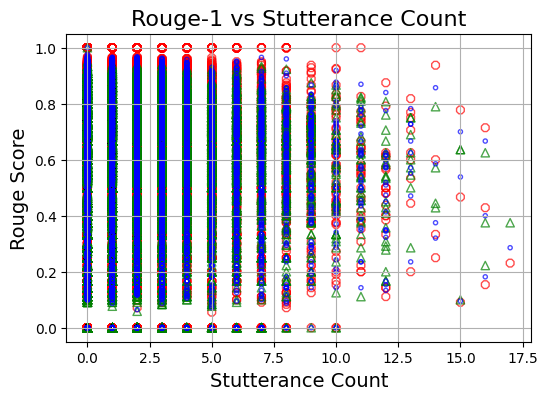

In [32]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rouge1-precision"], 
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rouge1-recall"], 
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

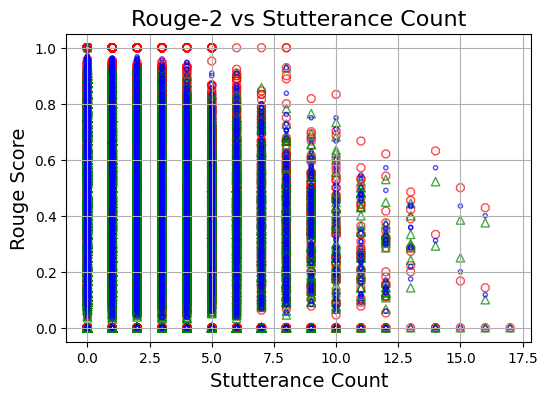

In [33]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rouge2-precision"], 
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rouge2-recall"], 
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

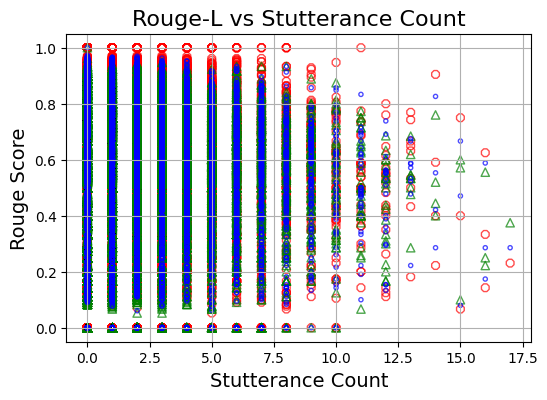

In [34]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rougel-precision"], 
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rougel-recall"], 
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_wav2vec["Stutterance_Count"], 
    net_aigenerated_data_wav2vec["rougel-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores (Wav2vec)

In [35]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Stutterance_Count'], net_aigenerated_data_wav2vec.dropna()['rouge1-precision'])
print(f"p-value [stuttering count & rouge-1 precision] = {p}")
print(f"rho [stuttering count & rouge-1 precision] = {rho}")

rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Stutterance_Count'], net_aigenerated_data_wav2vec.dropna()['rouge1-recall'])
print(f"p-value [stuttering count & rouge-1 recall] = {p}")
print(f"rho [stuttering count & rouge-1 recall] = {rho}")

rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Stutterance_Count'], net_aigenerated_data_wav2vec.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")

p-value [stuttering count & rouge-1 precision] = 7.461633441396865e-13
rho [stuttering count & rouge-1 precision] = 0.037439811539149395
p-value [stuttering count & rouge-1 recall] = 0.0
rho [stuttering count & rouge-1 recall] = 0.22241929847661965
p-value [stuttering count & rouge-1 f1] = 7.435529495952566e-131
rho [stuttering count & rouge-1 f1] = 0.12661613349404133
